# WC(P)S demo of JKI Datacubes
## PHASE (phenological phases), precipitation, and Soil-adjusted vegetation index (SAVI from Sentinel-2)

Florian Beyer  
florian.beyer@julius-kuehn.de  
Version 1.6 
2024-11-22

Abstract:  
The notebook demonstrates how to retrieve georaster data time series from the JKI Datecube via OGC webservices (WCS and WCPS) using Python.


**Data Cubes, What is that???**
The concept of datacubes is a new paradigm for storing and analyzing geo raster (e.g. Earth observation) data. Datacubes, which are multi-dimensional arrays (often spatiotemporal), offer significant advantages over traditional data storage methods by simplifying access to and analysis of large datasets.


Free datacubes -> PHASE & precipitation  
Restricted datacubes -> Sentinel-2 data

### necessary packages 

In [1]:
# standard packages
import json
import time
import io
import random

# important packages
import matplotlib.pyplot as plt # plotting
import numpy as np # numeric python
import pprint # print function for human-readable outputs
from tqdm import tqdm # progress bar

# geodata packages
import geopandas as gpd # handling geovector data
from shapely.geometry import Polygon # screate a polygon geometry from a set of vertices (coordinates)
import rasterio # handling georaster data

# own functions
import functions.func_misc as func_misc  # some additional defined functions

### additional required packages:
# numpy
# rasterio
# geopandas
# tqdm
# pprint
# xmltodict
# ipyleaflet
# pyproj

### credentials from credentials.py

In [2]:
import credentials # ---> this is the credentials.py

if credentials.ras_pw == '':
    print("It's possible that some of the following functions might not work without credentials, or you may only have limited access.\n Please check crdentials.py.")
else:
    print('credentials set!')

credentials set!


In [3]:
print('host adress of the JKI Data Cube: ', credentials.ras_host)

host adress of the JKI Data Cube:  https://datacube.julius-kuehn.de/flf/ows


# Get a list of all available data cubes
with credentials also possible to see restricted data cubes

In [4]:
list_of_datacubes = func_misc.get_coverages(
    host=credentials.ras_host,
    user=credentials.ras_user,
    pw=credentials.ras_pw,
    wcs_version='2.0.1',
    use_credentials=False, # set True if credentials available
    get_query=True
)
print('available data cubes n={} :\n'.format(len(list_of_datacubes)))

for nr, cube in enumerate(list_of_datacubes):
    print(nr, cube)

https://datacube.julius-kuehn.de/flf/ows?SERVICE=WCS&version=2.0.1&request=GetCapabilities
available data cubes n=75 :

0 DWD_Niederschlag_HYRAS
1 DWD_Temp_Max_OLD
2 DWD_Temp_Min_OLD
3 DWD_Temp_Tagesmittel_OLD
4 DWD_pawXcult001X1kmXambav2_daily
5 MODIS
6 S1_Backscatter
7 S1_Coherence
8 S1_Vegetation_Index
9 dwd_eminX1kmXdynawi_daily
10 dwd_evaporationXfarmlandXhaude_daily
11 dwd_evaporationXp_daily
12 dwd_evapotranspiration_daily
13 dwd_iconXd2Xclct_hourly
14 dwd_iconXd2XrelhumX2m_hourly
15 dwd_iconXd2XtX2m_hourly
16 dwd_iconXd2XuX10m_hourly
17 dwd_iconXd2XvX10m_hourly
18 dwd_iconXd2Xww_hourly
19 dwd_pawX1kmXdynawi_daily
20 dwd_pawXcult001X1kmXdynawi_daily
21 dwd_pawcrdXcult001X1kmXdynawi_daily
22 dwd_precipitationXradolanXgreater10mmXnumberXhours_daily
23 dwd_precipitation_daily
24 dwd_precipitation_daily_OLD
25 dwd_rfmitX1kmXdynawi_daily
26 dwd_rr24X1kmXdynawi_daily
27 dwd_rrgt10mX1kmXdynawi_daily
28 dwd_rrmaxX1kmXdynawi_daily
29 dwd_rrsumX1kmXdynawi_daily
30 dwd_tempXmaxXforecast_da

# Get metadata of given data cube
with credentials also possible to see restricted data cubes

In [5]:
datacube_layer = random.choice(list_of_datacubes)
datacube_layer

'dwd_evapotranspiration_daily'

In [6]:
metadata = func_misc.get_metadata_from_datacube(
    layer=datacube_layer,
    host=credentials.ras_host,
    user=credentials.ras_user,
    pw=credentials.ras_pw,
    use_credentials=False # set True if credentials available
)
print('meta data of data cube {}:\n'.format(datacube_layer))
print(json.dumps(metadata, indent=4))

meta data of data cube dwd_evapotranspiration_daily:

{
    "wcs:CoverageDescriptions": {
        "@xsi:schemaLocation": "http://www.opengis.net/wcs/2.0 http://schemas.opengis.net/wcs/2.0/wcsDescribeCoverage.xsd",
        "@xmlns:wcs": "http://www.opengis.net/wcs/2.0",
        "@xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
        "@xmlns:gml": "http://www.opengis.net/gml/3.2",
        "@xmlns:swe": "http://www.opengis.net/swe/2.0",
        "@xmlns:ows": "http://www.opengis.net/ows/2.0",
        "@xmlns:xlink": "http://www.w3.org/1999/xlink",
        "@xmlns:ras": "http://www.rasdaman.org",
        "@xmlns:gmlcov": "http://www.opengis.net/gmlcov/1.0",
        "wcs:CoverageDescription": {
            "@gml:id": "dwd_evapotranspiration_daily",
            "gml:boundedBy": {
                "gml:Envelope": {
                    "@srsName": "http://www.opengis.net/def/crs-compound?1=http://www.opengis.net/def/crs/OGC/0/AnsiDate&2=http://www.opengis.net/def/crs/EPSG/0/25832",
  

# Example Winter Wheat field in 2020

In [7]:
# directory to shape file of agricultural field'
shp = 'data/winterwheat2020.geojson'
# shp = 'data/thueringen_groß.geojson'
# shp = 'data/niedersachsen.geojson'
# shp = 'data/bayern.geojson'

In [8]:
### shows vector in an interactive map
## works only if you installed ipyleaflet 
##  more infor,mation here: https://github.com/jupyter-widgets/ipyleaflet
## restarting the jupyterlab after installation is maybe required
func_misc.get_map(shp, zoom=15)

Map(center=[52.20607611445892, 10.39525994822609], controls=(ZoomControl(options=['position', 'zoom_in_text', …

# 1. Collecting PHASE data from JKI DataCube
## Germany-wide phenological data

Germany-wide and spatio-temporally consistent 1 x1 km² analysis-ready time series of interpolated days of the year (DOYs).  
The data set covers 56 **entry dates of phenological development stages** of 9 main crop types for the period between 1993 and 2021.  
The derivation of the 1624 records is based on phenological observations provided by German Meteorological Service (DWD) and the PHASE model, which combines the concept of growing degree days (GDD) with a geostatistical interpolation procedure. 

SWAGGER page für JKi webservice: https://sf.julius-kuehn.de/openapi/weather/

The name of the data cube is: **jki_phaseX202Xwinterwheat_annually**  
**jki** = data origin  
**phase** = data name  
**202** = crop type code (DWD)  
**winterwheat** = croptype  
**annually** = regular data acquistion

Citation and further information:  
Gerstmann, H., Doktor, D., Gläßer, C., & Möller, M. (2016). PHASE: A geostatistical model for the Kriging-based spatial prediction of crop phenology using public phenological and climatological observations. Computers and Electronics in Agriculture, 127, 726–738. https://doi.org/10.1016/j.compag.2016.07.032  
Gerstmann, H., Gläßer, C., Thürkow, D., & Möller, M. (2018). Detection of Phenology-Defined Data Acquisition Time Frames For Crop Type Mapping. PFG – Journal of Photogrammetry, Remote Sensing and Geoinformation Science, 86(1), 15–27. https://doi.org/10.1007/s41064-018-0043-6  
Möller, M., Boutarfa, L., & Strassemeyer, J. (2020). PhenoWin – An R Shiny application for visualization and extraction of phenological windows in Germany. Computers and Electronics in Agriculture, 175, 105534. https://doi.org/10.1016/j.compag.2020.105534  
Möller, M., Beyer, F., Dierks, M., Horney, P., Baumann, P., Svoboda, N., & Gerstmann, H. (2023). Germany-wide time series of interpolated phenological observations of main crop types between 1993 and 2021 (preprint). Eartharxiv.Org, 1–20. https://doi.org/10.31223/X5D37T

In [9]:
# function to request PHASE data using WCS query
from functions.func_datacube_PHASE import get_phases_from_point

In [10]:
cube_name='jki_phaseX202Xwinterwheat_annually'

In [11]:
metadata = func_misc.get_metadata_from_datacube(
    layer=cube_name,
    host=credentials.ras_host,
    user=credentials.ras_user,
    pw=credentials.ras_pw,
    use_credentials=False # set True if credentials available
)

band_info = metadata['wcs:CoverageDescriptions']['wcs:CoverageDescription']['gmlcov:rangeType']['swe:DataRecord']['swe:field']

print(f'number of bands: {len(band_info)}\n')
print('band number: band name | band description')

band_dict = {}
for i, band in enumerate(band_info):
    print(f'  Band {i+1}: {band_info[i]['@name']} | {band_info[i]['swe:Quantity']['swe:description']}')
    band_dict[i+1] = [band_info[i]['@name'], band_info[i]['swe:Quantity']['swe:description']]

number of bands: 14

band number: band name | band description
  Band 1: doy15 | Beginning of shooting elongation
  Band 2: doy18 | Beginning of heading emergence
  Band 3: doy19 | Beginning of milk ripening
  Band 4: doy21 | Beginning of yellow ripening
  Band 5: doy24 | Harvest
  Band 6: doy10 | Beginning of sowing
  Band 7: doy12 | Emergence
  Band 8: sse15 | Beginning of shooting elongation - sum of squares error
  Band 9: sse18 | Beginning of heading emergence - sum of squares error
  Band 10: sse19 | Beginning of milk ripening - sum of squares error
  Band 11: sse21 | Beginning of yellow ripening - sum of squares error
  Band 12: sse24 | Harvest - sum of squares error
  Band 13: sse10 | Beginning of sowing - sum of squares error
  Band 14: sse12 | Emergence - sum of squares error


In [12]:
%%time
print('Potential starting dates of phenological phases for winter wheat:\n')
# get centroid coodinates from field
easting = float(gpd.read_file(shp).to_crs('EPSG:32632').centroid.x)
northing = float(gpd.read_file(shp).to_crs('EPSG:32632').centroid.y)

# phenological phases for winter wheat
# p_names = ['shooting','heading', 'milk ripening','yellow ripening','harvest', 'sowing', 'emergence']

# get phases from previous year
year_pre = '2019'
days_pre = func_misc.get_all_dates(year_pre)

# wcs request:
phases_pre = get_phases_from_point(
    year=year_pre,
    cube=cube_name,
    easting=easting,
    northing=northing,
    epsg=32632,
    host=credentials.ras_host,
    printout=False,
    get_query=False
)

# print result for previous year (sowing and emegrence)
# for i in range(5,7):
#     print('{} started on DOY {} in year {}'.format(p_names[i], int(phases_pre[i]), year_pre))
print(f'{band_dict[6][1]}: {phases_pre[5]}')
print(f'{band_dict[7][1]}: {phases_pre[6]}')

# get phases from ongoing year
year_on = '2020'    
days_on= func_misc.get_all_dates(year_on)

# wcs request:
phases_on = get_phases_from_point(
    year=year_on,
    cube=cube_name,
    easting=easting,
    northing=northing,
    epsg=32632,
    host=credentials.ras_host,
    printout=False,
    get_query=False
)

# print result for ongoing year (shooting - harvest)
# for i in range(0,5):
#     print('{} started on DOY {} in year {}'.format(p_names[i], int(phases_on[i]), year_on))

print(f'{band_dict[1][1]}: {phases_pre[0]}')
print(f'{band_dict[2][1]}: {phases_pre[1]}')
print(f'{band_dict[3][1]}: {phases_pre[2]}')
print(f'{band_dict[4][1]}: {phases_pre[3]}')


Potential starting dates of phenological phases for winter wheat:



<timed exec>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
<timed exec>:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


Beginning of sowing: 276.6461
Emergence: 290.2246
Beginning of shooting elongation: 104.3585
Beginning of heading emergence: 147.3462
Beginning of milk ripening: 167.0573
Beginning of yellow ripening: 187.2016
CPU times: user 53.7 ms, sys: 7.4 ms, total: 61.1 ms
Wall time: 433 ms


## plot phenological data (PHASE data)

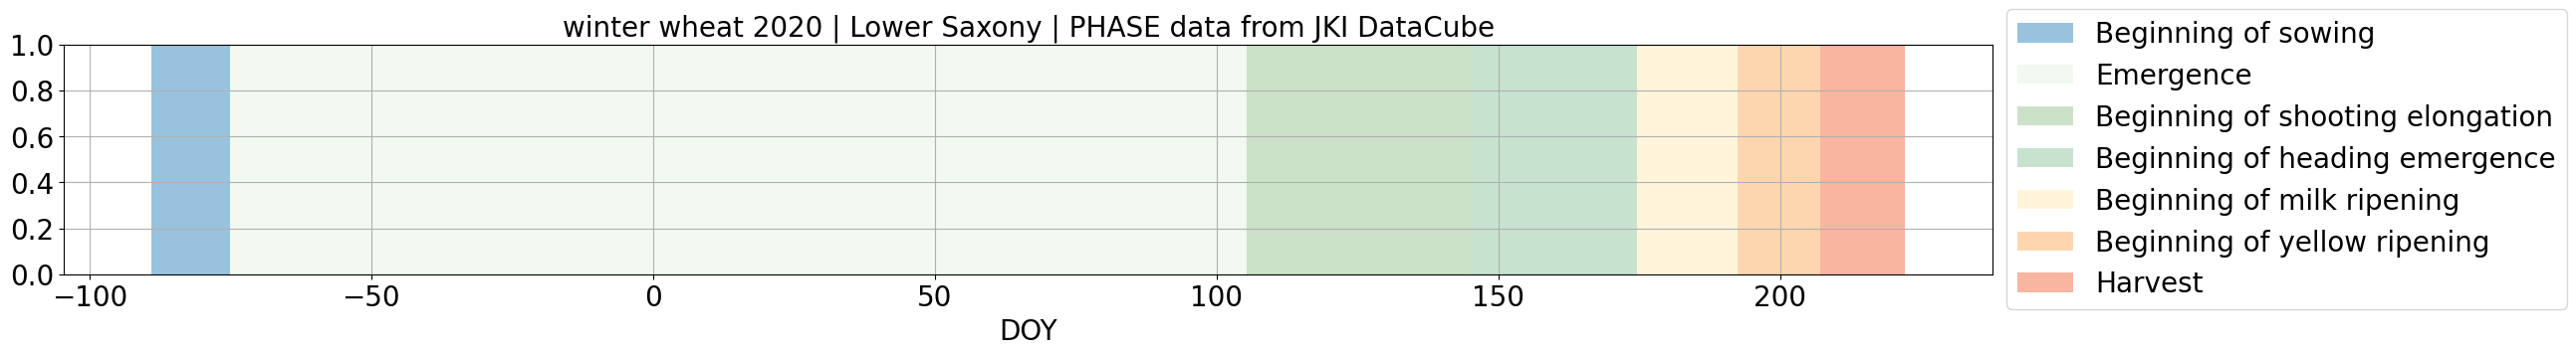

In [13]:
# plot phenological phases
fig, ax = plt.subplots(figsize=(25,3))

# get start of phases from previous year
sow = -1 * (len(days_pre) - np.floor(phases_pre[5]))
eme = -1 * (len(days_pre) - np.floor(phases_pre[6]))

ax.axvspan(sow,eme , facecolor= '#3287BD', alpha=0.5, label=f'{band_dict[6][1]}')
ax.axvspan(eme,phases_on[0] , facecolor= '#E6F4E3', alpha=0.5, label=f'{band_dict[7][1]}')
# ax.axvspan(0, phases[0], facecolor= '#E6F4E3', alpha=0.5, label='emergence')
ax.axvspan(phases_on[0], phases_on[1], facecolor= '#9AC693', alpha=0.5, label=f'{band_dict[1][1]}')
ax.axvspan(phases_on[1], phases_on[2], facecolor= '#93C7A3', alpha=0.5, label=f'{band_dict[2][1]}')
ax.axvspan(phases_on[2], phases_on[3], facecolor= '#FEEDB9', alpha=0.5, label=f'{band_dict[3][1]}')
ax.axvspan(phases_on[3], phases_on[4], facecolor= '#FDAE61', alpha=0.5, label=f'{band_dict[4][1]}')
ax.axvspan(phases_on[4], phases_on[4]+15, facecolor= '#F56D43', alpha=0.5, label=f'{band_dict[5][1]}')
ax.grid()
ax.set_xlabel('DOY', fontsize=20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('winter wheat 2020 | Lower Saxony | PHASE data from JKI DataCube', fontsize=20)
# plt.savefig('/directory/to/save/the/figure/winterwheat_field_2020_PHASES.pdf',bbox_inches='tight')
plt.show()



In [14]:
sowing = int(np.floor(phases_pre[5]))
print('start of sowing (DOY): ', sowing)

start of sowing (DOY):  276


In [15]:
print('number of days from sowing to the last day of the previous year: ', len(days_pre)-sowing)

number of days from sowing to the last day of the previous year:  89


In [16]:
harvest = int(np.ceil(phases_on[4]))+15 # period 15 days of potential harvesting
print('start of harvest (DOY): {}\nend of harvest set to (DOY): {}'.format(int(np.ceil(phases_on[4])), harvest))

start of harvest (DOY): 208
end of harvest set to (DOY): 223


# 2. Collecting EO data from JKI DataCube

Sentinel-2 data will be requested and vegetation index SAVI will be calulated on the fly


SWAGGER page für JKi webservice: https://sf.julius-kuehn.de/openapi/phase/

**The following SAVI request might fail, if you do not have credentials.**  
**You have to be a registered user to request Remote Sensing data from JKI Sentinel-2 data cube!!!**

If you are an **unregisted user**, then jump to [**part 3 Precipitation**](#precipitation) and preceed with the notebook without EO data. 

The name of the data cube is: **codede_reflectanceXboaXs2gg_irregular**  
**codede** = data origin  
**reflectance** = data unit (in % * 100)  
**boa** = bottom of atmosphere
**s2gg** = S2_GermanyGrid (name of the ARD data)  
**irregular** = no regular acquisition

In [17]:
# function to request Sentinel-2 data from S2_GermanyGrid using WCS query
from functions.func_datacube_S2_WCPS import wcps_savi

In [18]:
cube_name='codede_reflectanceXboaXs2gg_irregular'
valid_pixels = 40 # describes a threshold of mininmal valid pixels for the given geometry. So, with in the polygon there should be at least 40 % of pixels without null values.
polygon = Polygon(list(gpd.read_file(shp).to_crs('EPSG:32632').boundary[0].coords)).wkt

In [19]:
%%time
img_pre = wcps_savi(
    cube=cube_name,
    polygon=polygon,
    dates=days_pre[sowing:],
    # dates=days_on[:15],
    user=credentials.ras_user,
    pw=credentials.ras_pw,
    host=credentials.ras_host,
    printout=False,
    query_url=False
)

CPU times: user 24.7 ms, sys: 11 ms, total: 35.7 ms
Wall time: 2.32 s


In [20]:
%%time
img_on = wcps_savi(
    cube=cube_name,
    polygon=polygon,
    dates=days_on[:harvest],
    # dates=days_on[:15],
    user=credentials.ras_user,
    pw=credentials.ras_pw,
    host=credentials.ras_host,
    printout=False,
    query_url=False
)

CPU times: user 54.3 ms, sys: 8.66 ms, total: 62.9 ms
Wall time: 5.62 s


In [21]:
# collecting the request results in one dictionary
# SAVI images were requested day-wise, although Sentinel-2 acquistion is every 3 to 5 days 
# thus, this for loops extract dates with acquired data
# no data dates and cloudy dates (valid_pixels threshold) are not further considered
dict_field_wcps = {}
for i, date in enumerate(days_pre[sowing:]):
    with rasterio.open(io.BytesIO(img_pre.content), nodata=0) as src:
        band = src.read(i+1)
    vp_calculted = np.count_nonzero(band !=0) / band.size *100
    if np.sum(band) > 0 and vp_calculted >= valid_pixels:
        dict_field_wcps[date] = band
for i, date in enumerate(days_on[:harvest]):
    with rasterio.open(io.BytesIO(img_on.content), nodata=0) as src:
        band = src.read(i+1)
    vp_calculted = np.count_nonzero(band !=0) / band.size *100
    if np.sum(band) > 0 and vp_calculted >= valid_pixels:
        dict_field_wcps[date] = band

print('number of collected images = {} (valid pixel portion >= {} %)'.format(len(dict_field_wcps), valid_pixels))

number of collected images = 44 (valid pixel portion >= 40 %)


## plot SAVI data (vegetation index)

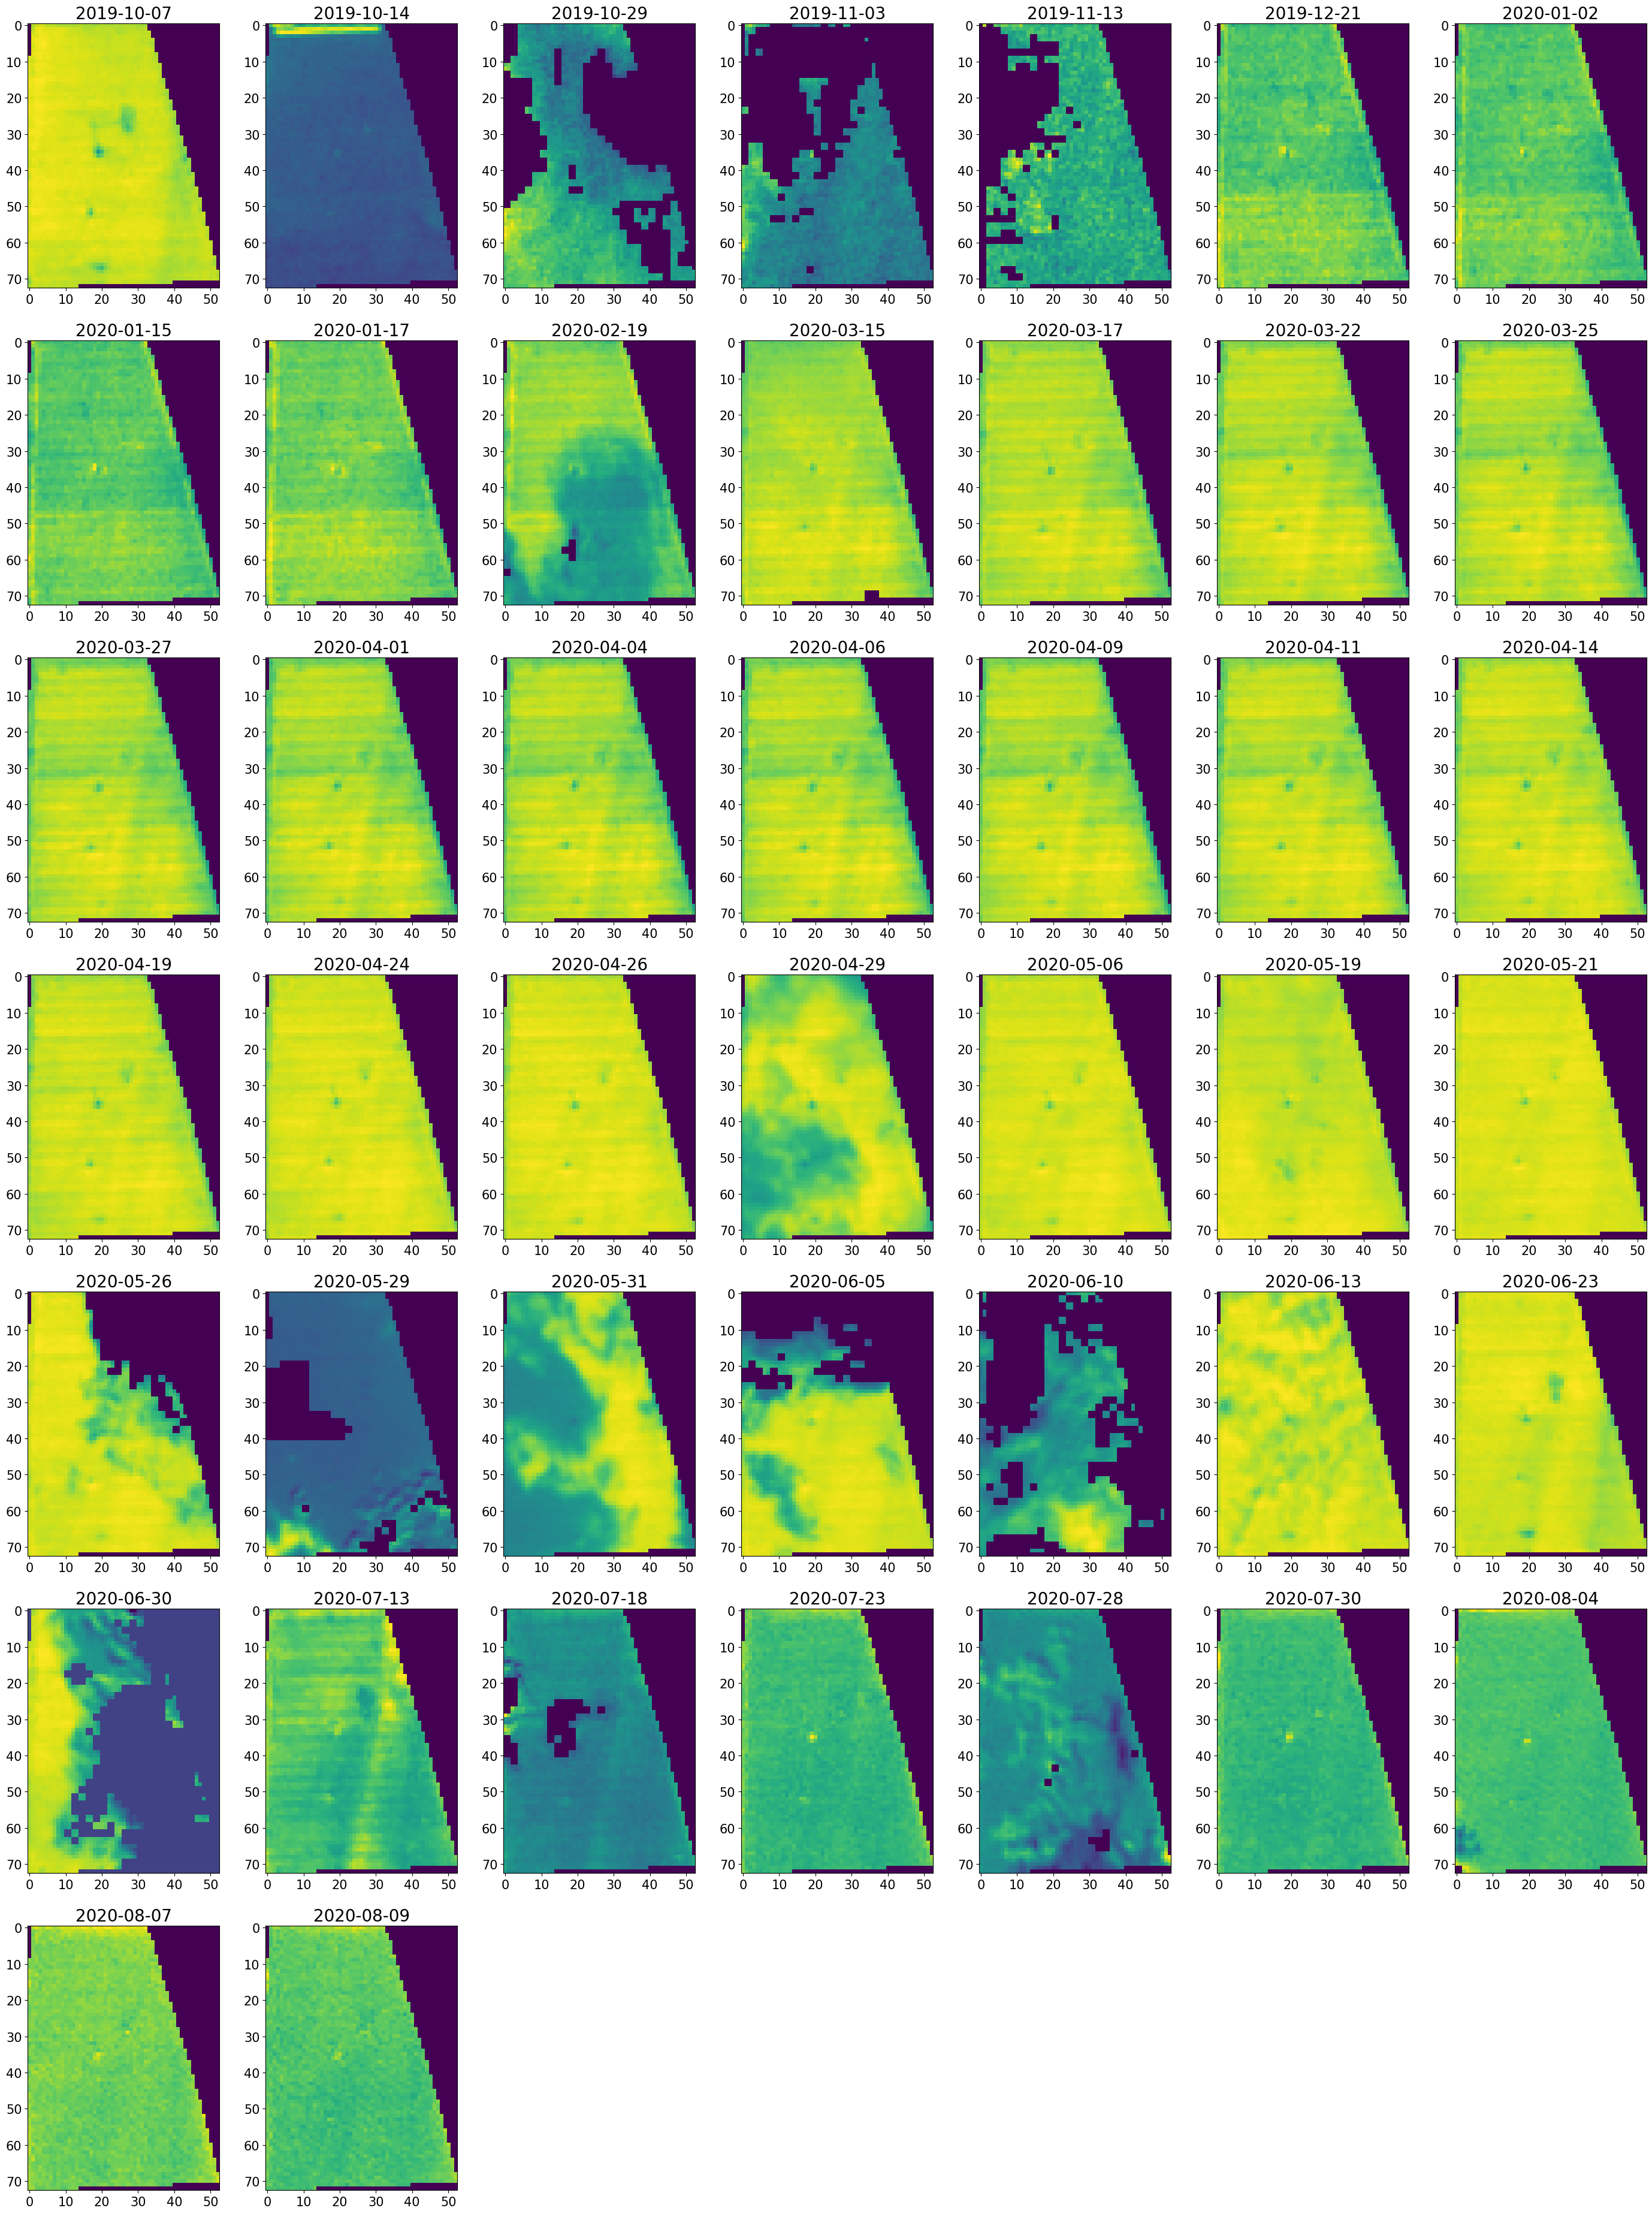

In [22]:
cols = 7
rows = int(np.ceil(len(dict_field_wcps)/2))
fig = plt.figure(figsize=(35,150))
for i, date in enumerate(dict_field_wcps):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(dict_field_wcps[date])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(date, fontsize=20)
# plt.savefig('/directory/to/save/the/figure/winterwheat_field_2020_SAVI_dates.pdf',bbox_inches='tight')
plt.show()

<a id="precipitation"></a>
# 3. Collecting precipitation data from JKI DataCube

Weather data from the DWD (German Weather Service) is automatically imported daily into the JKI DataCube for numerous parameters as part of a cooperation agreement.

SWAGGER page für JKi webservice: https://sf.julius-kuehn.de/openapi/phase/

The name of the data cube is: **dwd_precipitation_daily**  
**dwd** = data origin (DWD -> German Weather Service)  
**precipitation** = parameter  
**daily** = regular data acquistion

In [23]:
# function to request PHASE data using WCS query
from functions.func_datacube_DWD import get_precipitation_from_point

In [24]:
cube_name='dwd_precipitation_daily'

In [25]:
%%time
# requesing precipitation data from previous year
precipitation_pre = get_precipitation_from_point(
    startdate=days_pre[0],
    enddate=days_pre[-1],
    cube=cube_name,
    easting=easting,
    northing=northing,
    host=credentials.ras_host,
    user=credentials.ras_user,
    pw=credentials.ras_pw,
    epsg=32632,
    printout=False,
    get_query=True,
    use_credentials=False # set True if credentials available
)
print('annual precipitation sum = {} mm\n'.format(np.sum(precipitation_pre)))

https://datacube.julius-kuehn.de/flf/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=dwd_precipitation_daily&SUBSET=ansi("2019-01-01T00:00:00.000Z","2019-12-31T11:59:00.000Z")&subsettingCrs=http://ows.rasdaman.org/def/crs/EPSG/0/32632&SUBSET=E(595342.5636430825)&SUBSET=N(5784876.418276947)&outputCrs=http://ows.rasdaman.org/def/crs/EPSG/0/32632&FORMAT=text/csv
annual precipitation sum = 569.7 mm

CPU times: user 21.1 ms, sys: 0 ns, total: 21.1 ms
Wall time: 272 ms


In [26]:
%%time
# requesing precipitation data from ongoing year
precipitation_on = get_precipitation_from_point(
    startdate=days_on[0],
    enddate=days_on[-1],
    cube=cube_name,
    easting=easting,
    northing=northing,
    host=credentials.ras_host,
    user=credentials.ras_user,
    pw=credentials.ras_pw,
    epsg=32632,
    printout=False,
    get_query=True,
    use_credentials=False
)
print('annual precipitation sum = {} mm\n'.format(np.sum(precipitation_on)))

https://datacube.julius-kuehn.de/flf/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=dwd_precipitation_daily&SUBSET=ansi("2020-01-01T00:00:00.000Z","2020-12-31T11:59:00.000Z")&subsettingCrs=http://ows.rasdaman.org/def/crs/EPSG/0/32632&SUBSET=E(595342.5636430825)&SUBSET=N(5784876.418276947)&outputCrs=http://ows.rasdaman.org/def/crs/EPSG/0/32632&FORMAT=text/csv
annual precipitation sum = 571.4 mm

CPU times: user 20.4 ms, sys: 0 ns, total: 20.4 ms
Wall time: 264 ms


## plot precipitation data (DWD data)

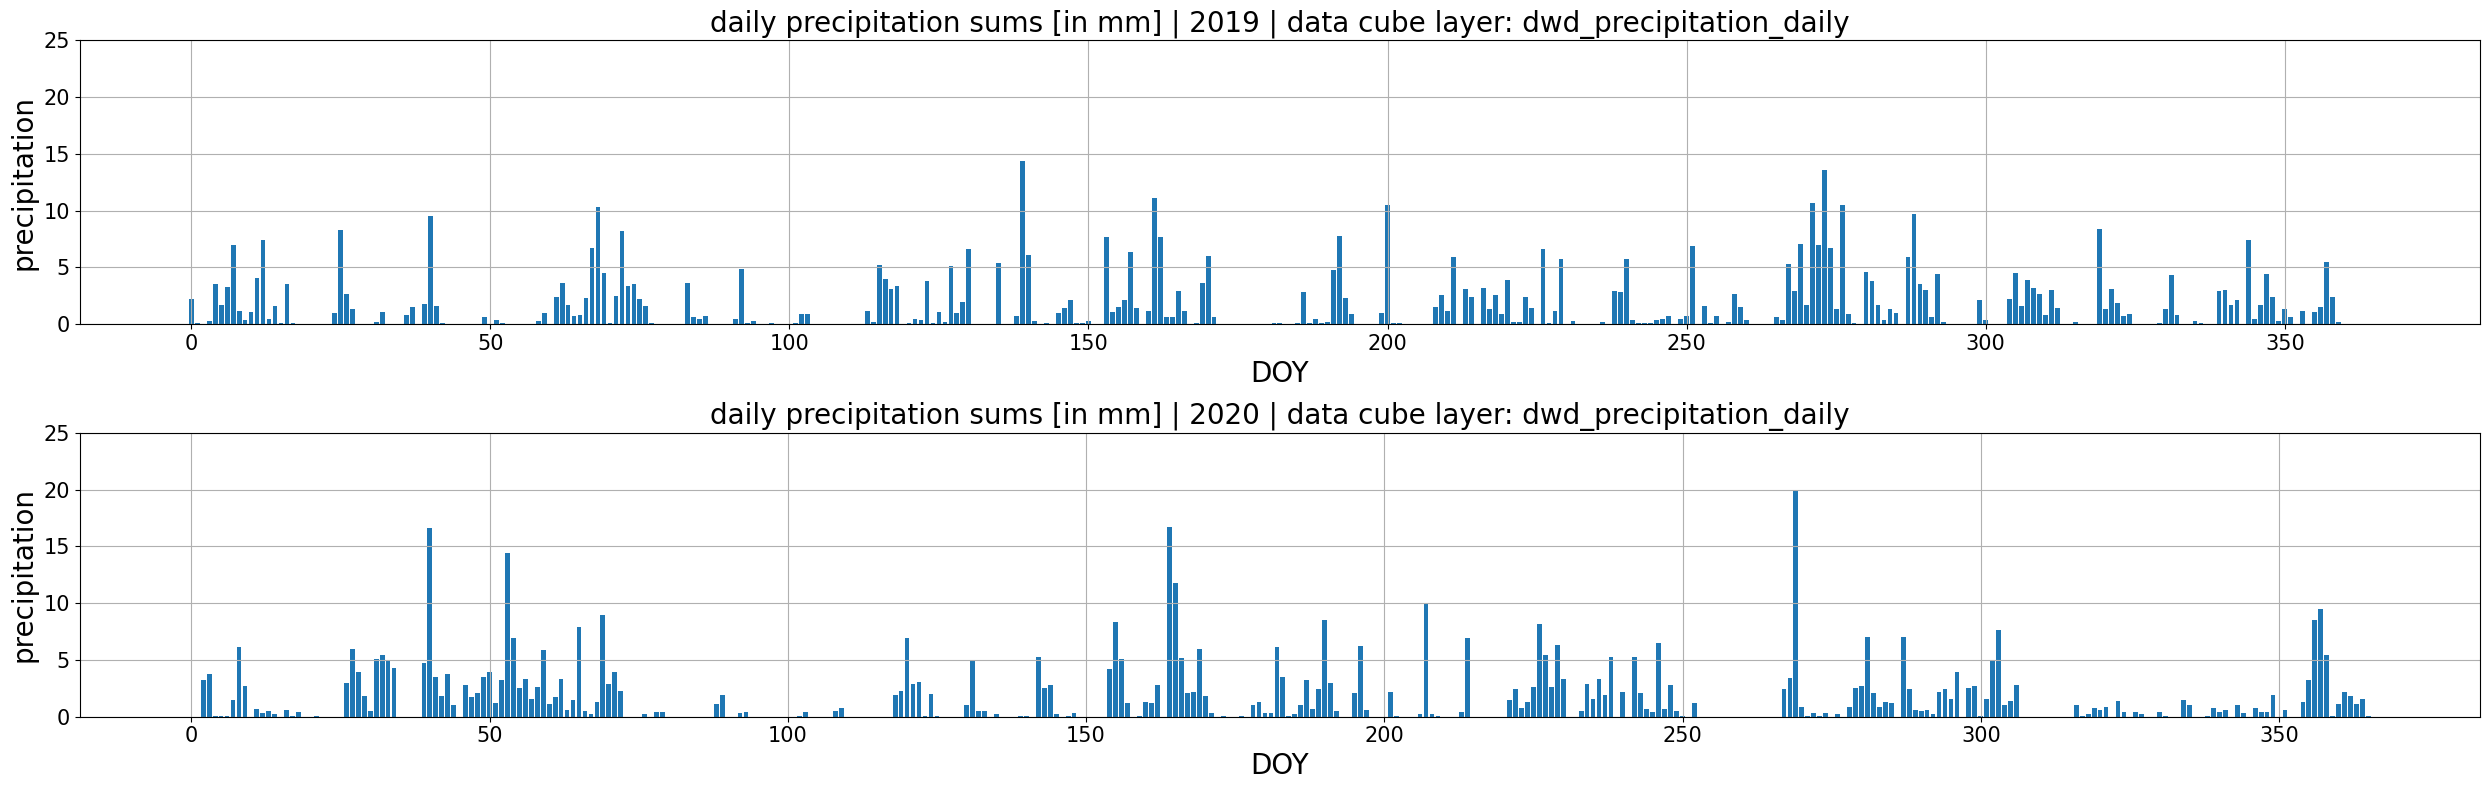

In [27]:
# plotting precipitation of both years

fig, axs = plt.subplots(2, 1, figsize=(25,8))
# plt.figure(figsize=(25,2))
axs[0].bar(range(len(precipitation_pre)), precipitation_pre)
axs[0].grid()
axs[0].set_title('daily precipitation sums [in mm] | 2019 | data cube layer: {}'.format(cube_name), fontsize = 20)
axs[0].set_xlabel('DOY', fontsize = 20)
axs[0].set_ylabel('precipitation', fontsize = 20)
axs[0].set_ylim(0,25)
axs[0].xaxis.set_tick_params(labelsize=15)
axs[0].yaxis.set_tick_params(labelsize=15)

axs[1].bar(range(len(precipitation_on)), precipitation_on)
axs[1].grid()
axs[1].set_title('daily precipitation sums [in mm] | 2020 | data cube layer: {}'.format(cube_name), fontsize = 20)
axs[1].set_xlabel('DOY', fontsize = 20)
axs[1].set_ylabel('precipitation', fontsize = 20)
axs[1].set_ylim(0,25)
axs[1].xaxis.set_tick_params(labelsize=15)
axs[1].yaxis.set_tick_params(labelsize=15)
fig.tight_layout()
# plt.savefig('/directory/to/save/the/figure/winterwheat_field_2020_precipitation.pdf',bbox_inches='tight')
plt.show()

# 4. Plotting all results

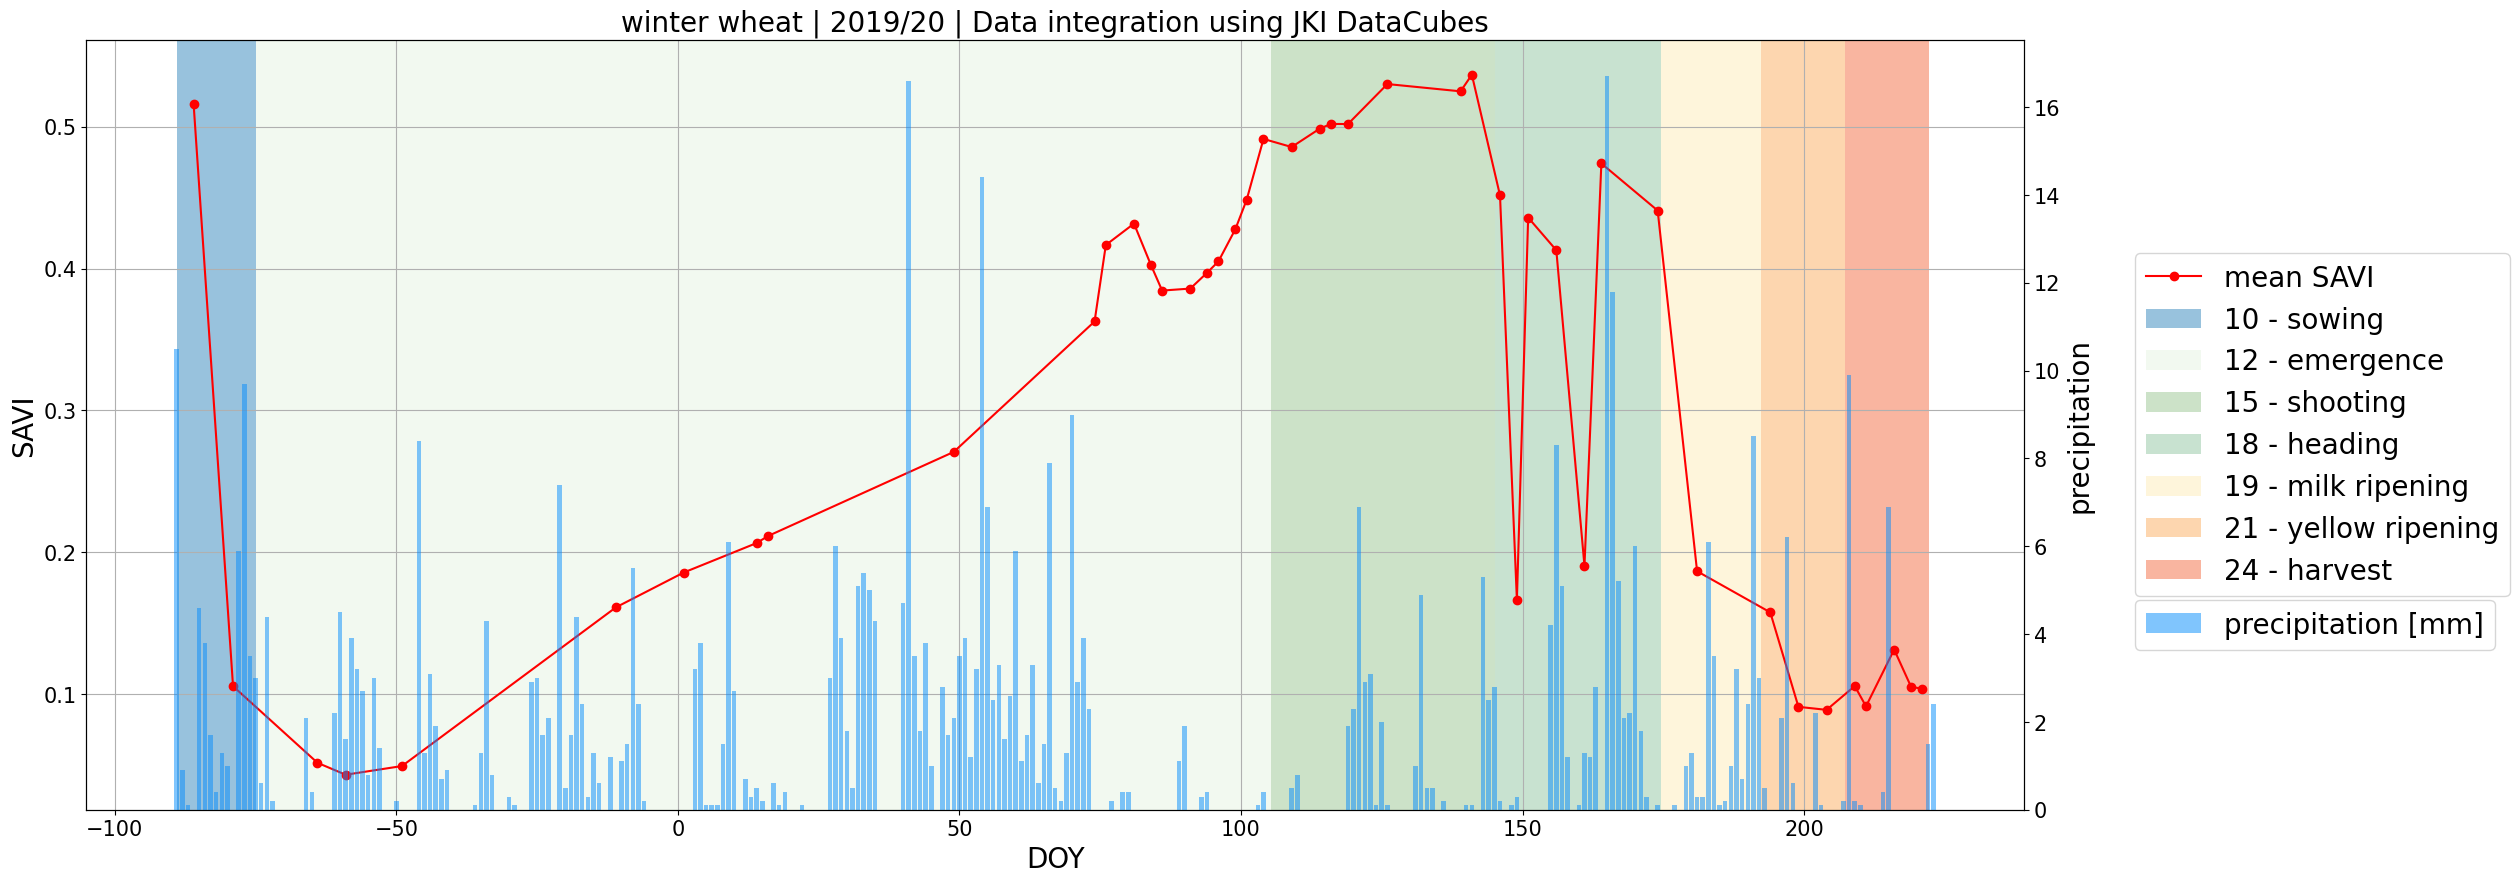

In [28]:
# calculating the mean SAVI of every aquisistion date

fig, ax = plt.subplots(figsize=(25,10))
if 'dict_field_wcps' in globals():
    
    savi = []
    x_savi = []
    for day in dict_field_wcps:
        savi_ = np.nanmean(dict_field_wcps[day])
        savi.append(savi_)

        for i, _date in enumerate(days_pre):
            if day==_date:
               x_savi.append(i-len(days_pre)) 
        for i, _date in enumerate(days_on):
            if day==_date:
               x_savi.append(i) 

    if len(savi) > 0:
        ax.plot(x_savi, savi, 'o-' ,c='red',label='mean SAVI')
    else:
        print('no SAVI data acquired or above 0...')
else:
    print('no SAVI data acquired...')
sow = -1 * (len(days_pre) - np.floor(phases_pre[5]))
eme = -1 * (len(days_pre) - np.floor(phases_pre[6]))
ax.axvspan(sow,eme , facecolor= '#3287BD', alpha=0.5, label='10 - sowing')
ax.axvspan(eme,phases_on[0] , facecolor= '#E6F4E3', alpha=0.5, label='12 - emergence')
# ax.axvspan(0, phases[0], facecolor= '#E6F4E3', alpha=0.5, label='emergence')
ax.axvspan(phases_on[0], phases_on[1], facecolor= '#9AC693', alpha=0.5, label='15 - shooting')
ax.axvspan(phases_on[1], phases_on[2], facecolor= '#93C7A3', alpha=0.5, label='18 - heading')
ax.axvspan(phases_on[2], phases_on[3], facecolor= '#FEEDB9', alpha=0.5, label='19 - milk ripening')
ax.axvspan(phases_on[3], phases_on[4], facecolor= '#FDAE61', alpha=0.5, label='21 - yellow ripening')
ax.axvspan(phases_on[4], phases_on[4]+15, facecolor= '#F56D43', alpha=0.5, label='24 - harvest')
ax.grid()
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax2 = ax.twinx()
ax2.bar(np.array(range(int(sow),0)), precipitation_pre[sowing:],alpha=0.5, color='#038cfc')
ax2.bar(np.arange(len(precipitation_on[:harvest]))+1, precipitation_on[:harvest],alpha=0.5, color='#038cfc', label='precipitation [mm]')
ax.set_ylabel('SAVI', fontsize=20)
ax.set_xlabel('DOY', fontsize=20)
ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.24), fontsize=20)
ax2.yaxis.set_tick_params(labelsize=15)
ax2.set_ylabel('precipitation', fontsize=20)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=20)
plt.title('winter wheat | 2019/20 | Data integration using JKI DataCubes', fontsize=20)
# plt.savefig('/directory/to/save/the/figure/winterwheat_field_2020_joint_plot.pdf',bbox_inches='tight')
plt.show()


# EXCURSUS: query for Sentinel-2 data using WCS instead of WCPS

If the Sentinel-2 data are downloaded via WCS, the SAVI calculation has to be done on the local machine.
This usually takes a bit longer because of the iteration of all days which have to be downloaded.

In [46]:
# function to request Sentinel-2 data from S2_GermanyGrid using WCS query
from functions.func_datacube_S2_WCPS import wcs_get_S2_imagery



# load and prepare polygon
polygon = gpd.read_file(shp).to_crs('EPSG:32632')
polygon = str(polygon.geometry[0]).replace(' (', '(')

In [ ]:
%%time
'''
This cell collects all available Sentinel-2 images available for the agricultural field.
The SAVI will be calculated in case the valid pixel portion is satisfied...
First, the previous year (2019) will be treated from sowing to the last day of the year, then the ongoing (target) year (2020) till the harvest period.
'''
# choose a minimum portion of valid pixels within the image [in %]
valid_pixels = 40

# first loop --> all available images from previous year
dict_field = {}
for i, day in enumerate(tqdm(days_pre[sowing:])):
    # requesing DataCube
    img = wcs_get_S2_imagery(
        polygon=polygon,
        cube=cube_name,
        date=day,
        user=credentials.ras_user, 
        pw=credentials.ras_pw,
        host=credentials.ras_host,
        epsg = 32632,
        band1='07_NIR10',
        band2='03_Red',
        band3='02_Green',
        band_subset=True,
        printout=False,
        get_query=False
    )
    
    # calculating SAVI
    index = func_misc.calculate_savi(img, valid_pixel_portion=valid_pixels)
    if isinstance(index, list):
        dict_field[day] = [index[0], index[1], i-(len(days_pre)-sowing)]            
    
# second loop --> all available images from ongoing year
for i, day in enumerate(tqdm(days_on[:harvest])):
    # requesing DataCube
    img = wcs_get_S2_imagery(
        polygon=polygon,
        cube=cube_name,
        date=day,
        user=credentials.ras_user, 
        pw=credentials.ras_pw,
        host=credentials.ras_host,
        epsg = 32632,
        band1='07_NIR10',
        band2='03_Red',
        band3='02_Green',
        band_subset=True,
        printout=False,
        get_query=False
    )
    
    # calculating SAVI
    index = func_misc.calculate_savi(img, valid_pixel_portion=valid_pixels)
    if isinstance(index, list):
        dict_field[day] = [index[0], index[1], i+1]
    

In [ ]:
print('number of collected images = {} (valid pixel portion >= {} %)'.format(len(dict_field), valid_pixels))

In [ ]:
## plot SAVI data (vegetation index)

In [ ]:
cols = 7
rows = int(np.ceil(len(dict_field)/2))
fig = plt.figure(figsize=(35,150))
for i, date in enumerate(dict_field):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(dict_field[date][0])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(date+' | DOY '+str(dict_field[date][2]), fontsize=20)
# plt.savefig('/directory/to/save/the/figure/winterwheat_field_2020_SAVI_dates.pdf',bbox_inches='tight')
plt.show()